# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Group 1 - Followers = >65k

After many trials we have settled on a 3 variable regression model that uses comments, likes and followers to predict our final reach estimate. 

In order to fit the model most accurately to a normal situation we had to remove special outliers. Instagram's algorithm produces larger variance in individual results. These results had a detremental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. However, we determined that issues arose when the ratio of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model.

For this group we have only included users with followers from 1 to 10,000 to better match the reactions to posts. 

Process:

- work with users that have  >65k followers.
- Change the confidence interval to 10% or 90%.

- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df2 = pd.read_csv('trial_1_2.csv')

First, look at the data

In [3]:
len(df2)

728018

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 300.

In [4]:
df2 = df2.loc[(df2['reach']>1)]
len(df2)

727924

### Set bin for follower count
Next we decided to remove rows that have less than 1000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. 

In [5]:
df2 = df2.loc[(df2['followers']>65000)]
len(df2)

99611

In [6]:
df2 = df2.loc[(df2['followers']>1)]

Setting comments to greater than zero to avoid zero division errors

In [7]:
df2 = df2.loc[(df2['comments']>=1)] # & (df2['comments']<=2000)
len(df2)

99125

Remove rows with less than 100 likes to eliminate outliers.

In [8]:
df2 = df2.loc[(df2['likes']>=1)]
len(df2)

99125

Remove wierd situations where there are more comments or likes than reach.

In [9]:
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]
len(df2)

97061

## Split the data sets into two - a test and a training data set: 

In [10]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df2, test_size=0.2)

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [11]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [12]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [13]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

(-0.0004, 1000)

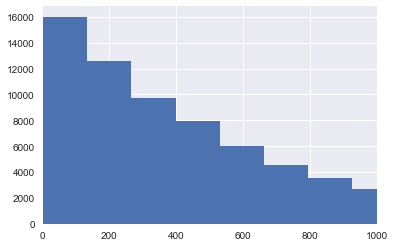

In [14]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-.0004,1000)

(-0.03, 3)

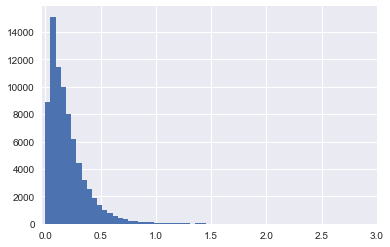

In [15]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.03,3)

(-0.003, 30)

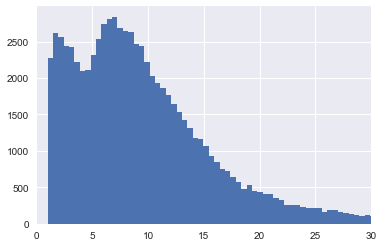

In [16]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30)

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [17]:
len(df2[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.05))])

3883

In [18]:
len(df2[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.95))])

3883

In [19]:
len(df2[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.95))])

3883

In [20]:
len(df2[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.05))])

3883

In [21]:
len(df2[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.05))])

3883

In [22]:
len(df2[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.95))])

3883

In [23]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [24]:
len(df2)

41263

Now, what does our data look like? 

(-0.0004, 1750)

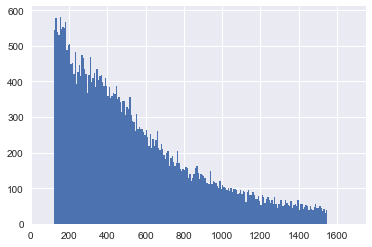

In [25]:
plt.hist(df2['reach_/_comments'], bins=200)
plt.xlim(-.0004,1750)

(-0.003, 25)

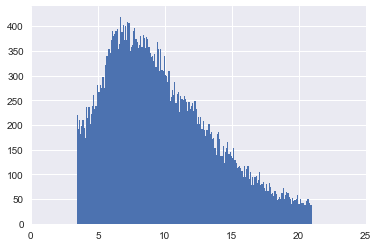

In [26]:
plt.hist(df2['reach_/_likes'], bins=200)
plt.xlim(-.003, 25)

(-0.002, 0.6)

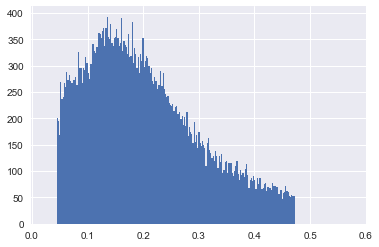

In [27]:
plt.hist(df2['reach_/_followers'], bins=200)
plt.xlim(-.002,.6)

# Fit the model

In [28]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 7.486e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:08:00   Log-Likelihood:            -4.5732e+05
No. Observations:               41263   AIC:                         9.147e+05
Df Residuals:                   41259   BIC:                         9.147e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -714.5096    116.279     -6.145      0.000    -942.419    -486.600
followers      0.0730      0.001    105.347      0.000       0.072       0.074
likes          4.7956      0.027    176.477      0.000       4.742       4.849
comments      48.8138      1.238     39.433      0.000      46.388      51.240
==============================================================================
Omnibus:                    15545.590   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           868611.055
Skew:                           1.024   Prob(JB):                         0.00
Kurtosis:                      25.384   Cond. No.                     3.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

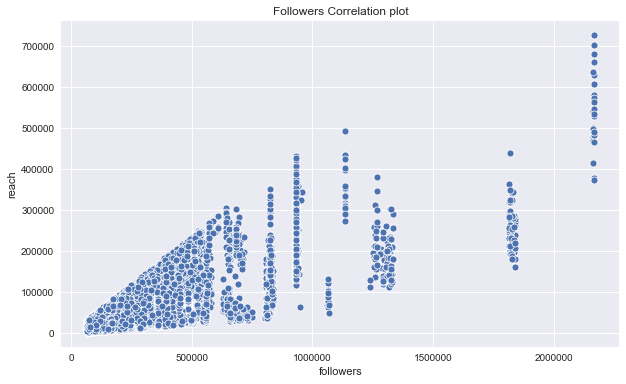

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

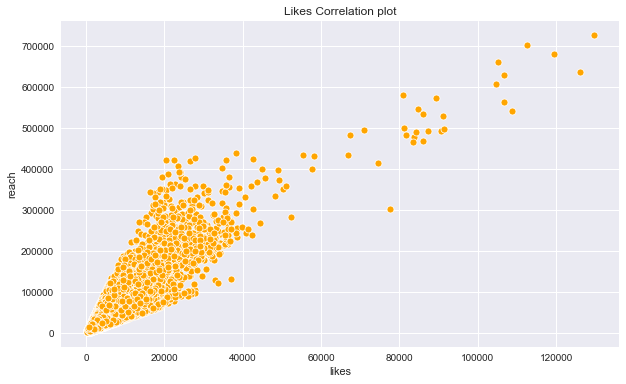

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

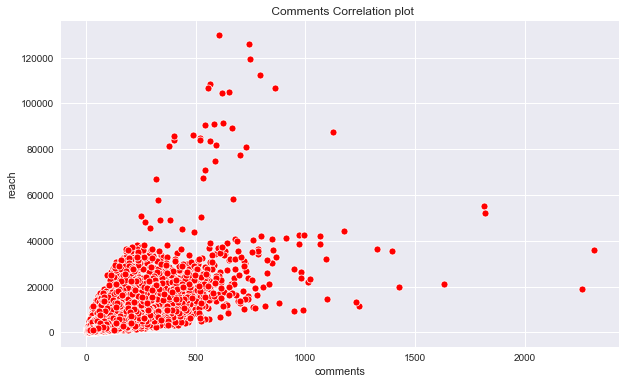

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [32]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 7.486e+04
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:08:02   Log-Likelihood:            -4.5732e+05
No. Observations:               41263   AIC:                         9.147e+05
Df Residuals:                   41259   BIC:                         9.147e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -714.5096    116.279     -6.145      0.000    -942.419    -486.600
followers      0.0730      0.001    105.347      0.000       0.072       0.074
likes          4.7956      0.027    176.477      0.000       4.742       4.849
comments      48.8138      1.238     39.433      0.000      46.388      51.240
==============================================================================
Omnibus:                    15545.590   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           868611.055
Skew:                           1.024   Prob(JB):                         0.00
Kurtosis:                      25.384   Cond. No.                     3.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Test the Model

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [33]:
test['test_reach'] = round(lr_model.predict(test),1)

In [34]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [35]:
test.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach,test_reach,reach_diff
108946,108946,75513,2017-06-25T14:23:05.000+00:00,689,6,5371,4357,8398.5,-4041.5
80612,80612,128315,2017-07-22T16:03:02.000+00:00,1193,54,13574,11035,17015.5,-5980.5
386133,386133,143798,2018-01-01T04:45:42.000+00:00,2994,24,47634,39434,25318.9,14115.1
362486,362486,96981,2018-05-11T15:52:38.000+00:00,5430,442,145925,108901,53985.4,54915.6
39688,39688,384729,2018-03-05T18:09:36.000+00:00,9881,239,22053,19826,86440.3,-66614.3


In [36]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

(-300, 300)

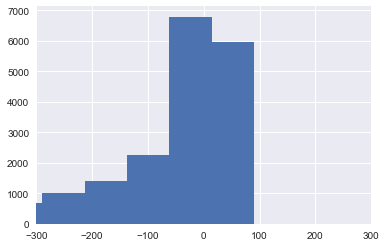

In [37]:
x = plt.hist(test.diff_ratio, bins = 100)
plt.xlim(-300, 300)

In [38]:
mean_squared_error(test.reach, test.test_reach)**.5

40231.16987351918

## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [39]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[7.26751394]
[314.95855187]
[0.19015784]


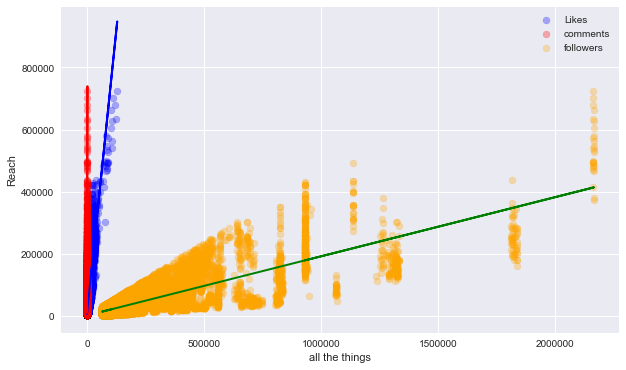

In [40]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of users with 65k and greater followers

Our 5th group produced some of the most varied results.  This user group has the widest range in user types. An account with 250,000 followers likely has different results than an account with 65,000 users. Additionally, at these larger numbers we can see bigger variation from the prediction. 

Our model has an r-squared of .849.  This is the highest of our models and tells us that 84% of the value can be determined by the correlation. 